# Edge detection with Convolutional Neural Network - Part 1

As suggested in [1], let's use the CNN kernel to perform edge detection

Learning goals:
- Understand convolution operation
- Understand convolution kernel
- Learn a kernel using machine learning techniques
- Do not start with a complex case like image recognition

### References:
1. Deep Learning, Chapter 9 - Ian Goodfellow, Yoshua Bengio, Aaron Courville
2. [Edge detection - Wikipedia](https://en.wikipedia.org/wiki/Edge_detection)
3. [Sobel operator - Wikipedia](https://en.wikipedia.org/wiki/Sobel_operator)
4. [Image convolution examples - AI Shake](http://aishack.in/tutorials/image-convolution-examples/)
5. [Learning to  perform linear filtering using natural image data - toward data science](https://towardsdatascience.com/learning-to-perform-linear-filtering-using-natural-image-data-db289d0b0457)

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow.keras import models, layers, losses, activations, regularizers, metrics
import tensorflow.keras.backend as K
import seaborn as sns
import tensorview as tv

In [2]:
if True:
    import os
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Convolution and correlation

Discrete convolution of frame X by a kernel K is defined in 2D as:
\begin{align}
S(i,j) = (X * K)(i,j) & = \sum_m \sum_n X(m, n) K(i-m, j-n) \\
& = \sum_m \sum_n X(i-m, j-n) K(m, n)
\end{align}

Convolution is commutative as stated in the equation above

Cross-correlation is very close but not commutative:
\begin{align}
S_cc(i,j) = (X * K)(i,j) & = \sum_m \sum_n X(i+m, j+n) K(m, n)
\end{align}

Also, in most cases the size of the kernel is quite small (3 x 3 to 7 x 7 in maching learning)

Using convolution is like using a dense (perceptron like) layer but sharing most of the coefficients. It leads to a drastic decrease in number or parameters (weights). Convolution kernels are fit to problems that are translation independent over the inputs. This is common on picture detectors or filters.

## Helpers

In [37]:
metricNames = ['loss', 'mean square error', 'Kullback Leibler divergence']

def plotHistory(hist, with_validation=False):
    """ Plot a classification history as outputted by Keras """
    fig, axes = plt.subplots(1, 3, figsize=(15,6), sharey=True)
    for m, ax in zip(metricNames, axes):
        ax.semilogy(hist.history[m])
        if with_validation:
            ax.semilogy(hist.history['val_'  + m])
            ax.legend(('train', 'valid'))
        ax.set_title(m)
        ax.set_xlabel('epoch')
        ax.grid()
        
def plotHeatMap(X, classes='auto', title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None, vmax=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    if vmax is not None:
        ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, fmt=fmt, 
                         cmap=plt.cm.bwr, ax=ax, vmin=-vmax, vmax=vmax) 
    else:
        ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, fmt=fmt, 
                         cmap=plt.cm.bwr, ax=ax) 
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)

## Using convolution to perform edge detection with a Sobel operator

Sobel operator [3] is a simple and efficient way to perform edge detection.

Let's build it with simple Python using an image of the Matterhorn at sunrise in Gray scale mode (1 channel)

(768, 1024)

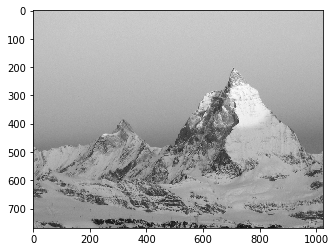

In [4]:
matterhornGray = cv2.imread('assets/Matterhorn_1024.JPG', cv2.IMREAD_GRAYSCALE)
plt.imshow(matterhornGray, cmap='gray')
testImageHeight  = matterhornGray.shape[0]
testImageWidth = matterhornGray.shape[1]
imageNChannels = 1
matterhornGray.shape

### Naive convolution algorithm

Two discrete convolutions are actually required, 1 for the horizontal edges, the other for the vertical edges. Both are then combined through a quadratic mean (L2 norm)

In [5]:
# Sobel operator for horizontal edge detection
Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
# Sobel operator for vertical edge detection
Ky = Kx.T

In [6]:
# Without using padding, the output array is 2 pixels shorter on each dimension
convolvedShape = (testImageHeight - 2, testImageWidth - 2)
matterhornEdges1x = np.zeros(convolvedShape) # Horiz
matterhornEdges1y = np.zeros(convolvedShape) # Vertical
matterhornEdges1  = np.zeros(convolvedShape) # Combined

for i in range(1, testImageHeight-1):
    for j in range(1, testImageWidth-1):
        window = matterhornGray[i-1:i+2, j-1:j+2]
        a = matterhornEdges1x[i-1, j-1] = np.maximum(np.sum(np.multiply(window, Kx)), 0)
        b = matterhornEdges1y[i-1, j-1] = np.maximum(np.sum(np.multiply(window, Ky)), 0)
        matterhornEdges1[i-1, j-1]      = np.sqrt(a**2 + b**2)

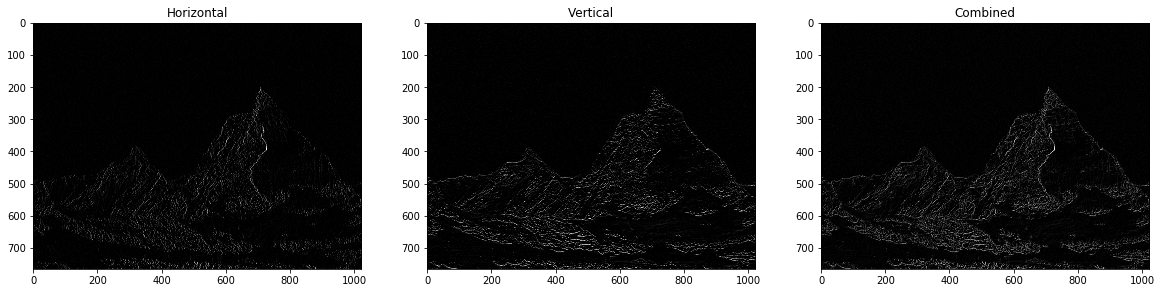

In [7]:
plt.figure(figsize=(20,7))
plt.subplot(1, 3, 1)
plt.imshow(matterhornEdges1x, cmap='gray');
plt.title('Horizontal')
plt.subplot(1, 3, 2)
plt.imshow(matterhornEdges1y, cmap='gray');
plt.title('Vertical')
plt.subplot(1, 3, 3)
plt.imshow(matterhornEdges1, cmap='gray');
plt.title('Combined');

This implementation could be vastly improved but that's not the goal of this tutorial

## Sobel filter with OpenCV


Let's apply the Sobel horizontal filter of OpenCV on a new image showing a trecker in a forest. This image will be used later as a train image.

In [8]:
forestGray = cv2.imread('assets/Forest_2048.jpg', cv2.IMREAD_GRAYSCALE)

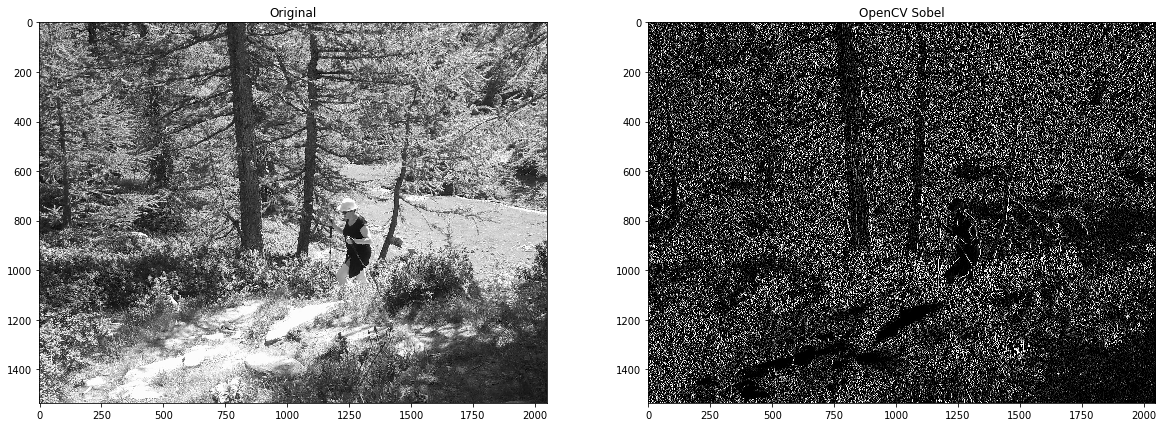

In [9]:
forestEdges2 = cv2.Sobel(forestGray, cv2.CV_8U, 1, 0, ksize=3)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))
for ax, im, title in zip(axes, [forestGray, forestEdges2], ['Original', 'OpenCV Sobel']):
    ax.set_title(title)
    ax.imshow(im, cmap='gray');

## Sobel filter in Keras

Let's build a filter in Keras to perform the horizontal Sobel filter. In this first step the filter weights are set by design. 

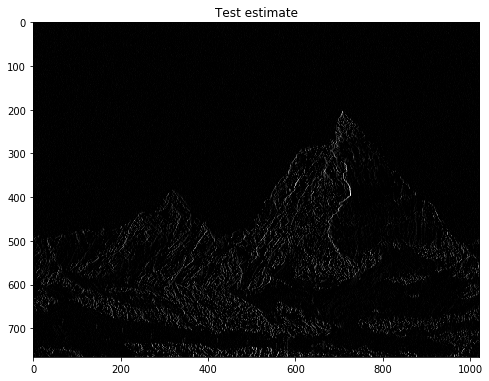

In [10]:
model0 = models.Sequential([
    # 2D convolutions 
    layers.Conv2D(1, (3, 3), activation=activations.relu, 
                        input_shape=(None, None, imageNChannels), name='conv0_0', use_bias=False,
                        weights=Kx.reshape(1,3,3,1,1)),
    layers.Reshape((-1, nConv))
], 'model0')

testImage = matterhornGray.reshape(1, testImageHeight, testImageWidth, 1) / 255
testEst0 = model0.predict(testImage)
testEstEdges0 = (testEst0.reshape(testImageHeight-2, testImageWidth-2)) * 255

plt.figure(figsize=(8, 8))
plt.imshow(testEstEdges0, cmap='gray');
plt.title('Test estimate');

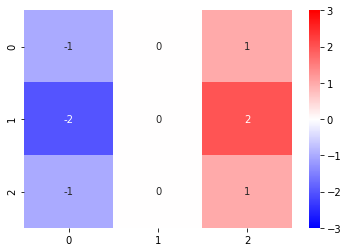

In [29]:
plotHeatMap(np.array(model0.get_weights()).reshape(3, 3), vmax=3)

We will see in the next section how to learn these coefficients

## Learn a convolutionnal neural net (CNN) as a filter

Using a simple two layer CNN to perform the filter composed here above.

### Prepare data

Train data is reshaped to be processed in squares of 64 x 64

In [12]:
trainHeight, trainWidth = 64, 64
inputBatchShape = (-1, trainHeight, trainWidth, imageNChannels)
trainImage  = forestGray.reshape(inputBatchShape) / 255

# Get the output of the fitler using model0 (filter with predefined weights)
trainImageHeight, trainImageWidth = forestGray.shape[0], forestGray.shape[1]
trainEst0 = model0.predict(forestGray.reshape(1, trainImageHeight, trainImageWidth, 1) / 255.)
trainEstEdges0 = np.pad((trainEst0.reshape(trainImageHeight-2, trainImageWidth-2)) * 255., (1,1), mode='constant')

# Reshape into sub-images as "Labels" for the trainer
outPutBatchShape = (-1, (trainHeight-2) * (trainWidth-2), imageNChannels)
trainLabels = trainEstEdges0.reshape(inputBatchShape)
trainLabels = trainLabels[:, 1:-1, 1:-1,:].reshape(outPutBatchShape) / 255.
trainImage.shape, trainLabels.shape

((768, 64, 64, 1), (768, 3844, 1))

### Model architecture and fit

Model is made of 1 convolution of 3 x 3. the output of the convolution is activated by the Leak-Relu. Leaky-Relu is similar to the Relu, that eliminates negative values. However, the leaky version is keeping a minor share of the negative values.

The Leaky-Relu is used in here to avoid vanishing gradients as most of the weights and data are close to 0 (see histogram below).

In [14]:
nEpochs = 4000
batchSize = 128

model1 = models.Sequential([
    layers.Conv2D(1, (3, 3), activation=activations.linear, # 2D convolution
                input_shape=(None, None, imageNChannels), use_bias=True, name='Conv2D',
                kernel_regularizer=regularizers.l1(0.001),
                bias_regularizer=regularizers.l1(0.01)
            ),
    layers.LeakyReLU(),
    layers.Flatten()
], 'model1')

model1.compile(optimizer='adam',
              loss=losses.mse,
              metrics=[metrics.mse, metrics.kullback_leibler_divergence])

# model1.summary()

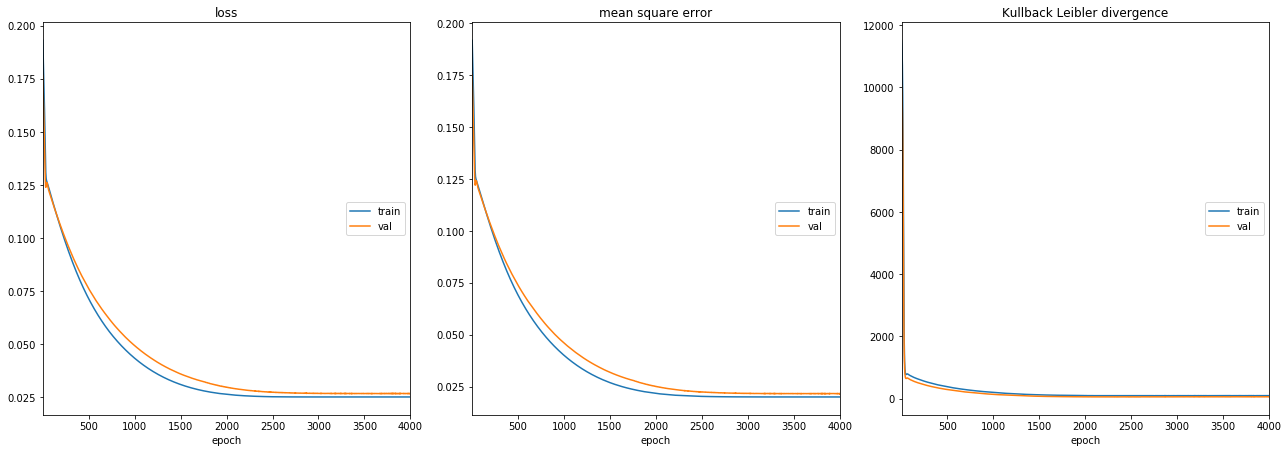

In [15]:
tv_plot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,6), columns=3, iter_num=nEpochs, wait_num=10)
hist1 = model1.fit(trainImage, trainLabels, 
                   epochs=nEpochs, batch_size=batchSize, 
                   validation_split=0.7, 
                   verbose=0,
                  callbacks=[tv_plot])

In [16]:
# plotHistory(hist1, True)

Convolution bias = 0.000488


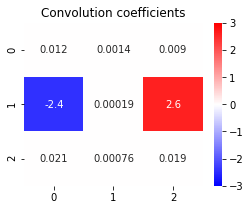

In [34]:
weights1 = model1.get_weights()
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
plotHeatMap(np.array(weights1[0]).reshape(3, 3)[:,:], ax=ax, title='Convolution coefficients', vmax=3)
print('Convolution bias = %.3g' % weights1[1])

### Test the model

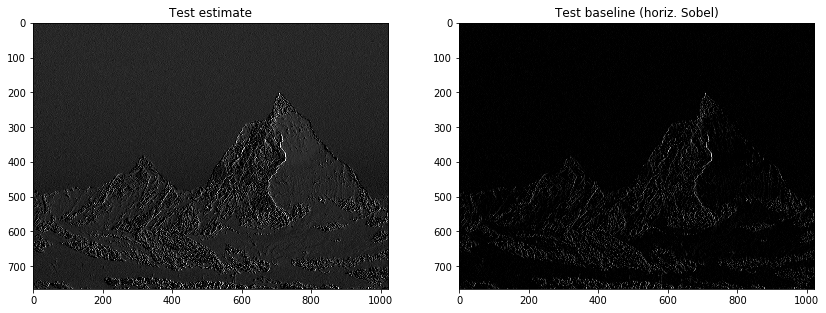

In [18]:
testImage = matterhornGray.reshape(1, testImageHeight, testImageWidth, 1) / 255
testEst = model1.predict(testImage)
testEstEdges = np.clip((testEst.reshape(testImageHeight-2, testImageWidth-2)) * 255, 0, 255)

plt.figure(figsize=(14, 8))
plt.subplot(1,2,1)
plt.imshow(testEstEdges, cmap='gray');
plt.title('Test estimate');
plt.subplot(1,2,2)
plt.imshow(testEstEdges0, cmap='gray');
plt.title('Test baseline (horiz. Sobel)');

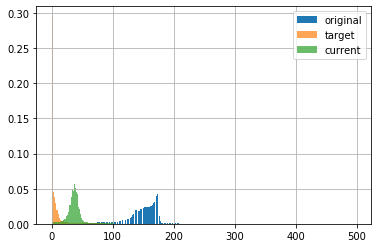

In [19]:
plt.hist((testImage.reshape(-1) * 255), 255, density=True, label='original')
plt.hist(testEstEdges0.reshape(-1), 255, density=True, alpha=0.7, label='target')
plt.hist(testEstEdges.reshape(-1), 255, density=True, alpha=0.7, label='current');
plt.legend()
plt.grid();

In [20]:
eval1 = model1.evaluate(testImage, testEstEdges0.reshape(1, -1, 1)  / 255., verbose=0)
print("Test image : loss (MSE + regularization) = %.3f, Mean Sq. Error = %.3f" % (eval1[0], eval1[1]))

Test image : loss (MSE + regularization) = 0.020, Mean Sq. Error = 0.015


The center line of the convolution filter has been correctly evaluated, even if a little high (absolute coefficient value is 3 instead of 2). The top and bottom rows are not properly evaluated.

## Multi convolution filter

In most cases of neural nets, a layer is made of several convolutions of the same size. Goal is to learn several features of the image and combine them in downstream layers.

Let's use a 2 convolution layer and a dense layer to combine them both.

In [21]:
nEpochs = 4000
batchSize = 128
nConv = 2

model2 = models.Sequential([
    layers.Conv2D(nConv, (3, 3), activation=activations.linear, # 2D convolution
                input_shape=(None, None, imageNChannels), use_bias=True,
                kernel_regularizer=regularizers.l1(0.001),
                bias_regularizer=regularizers.l1(0.01)
                ),
    layers.LeakyReLU(),
    layers.Dense(1, kernel_regularizer=regularizers.l1(0.0001)),
    layers.Flatten()
], 'model2')

model2.compile(optimizer='adam',
              loss=losses.mse,
              metrics=[metrics.mse, metrics.kullback_leibler_divergence])

# model2.summary()

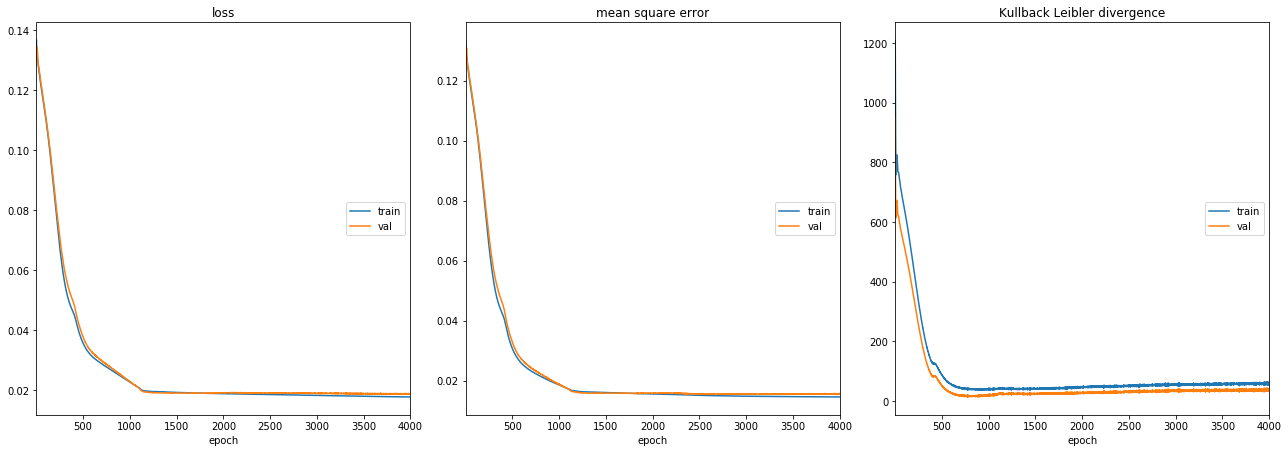

In [22]:
tv_plot = tv.train.PlotMetricsOnEpoch(metrics_name=metricNames,
                                      cell_size=(6,6), columns=3, iter_num=nEpochs, wait_num=10)
hist2 = model2.fit(trainImage, trainLabels, 
                   epochs=nEpochs, batch_size=batchSize, 
                   validation_split=0.7, 
                   verbose=0,
                  callbacks=[tv_plot])

In [23]:
#plotHistory(hist2, True)

Convolution biases = -1.242e-04, -3.653e-04
Dense bias = 1.179e-02


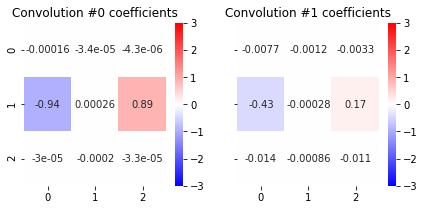

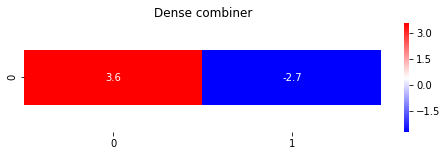

In [38]:
weights2 = model2.get_weights()
fig, axes = plt.subplots(1, nConv, figsize=(3 * nConv + 1, 3), sharey=True)
for i, ax in enumerate(axes):
    plotHeatMap(np.array(weights2[0]).reshape(3, 3, nConv)[:,:,i], ax=ax, title='Convolution #%d coefficients' % i, vmax=3)
print('Convolution biases = %.3e, %.3e' % (weights2[1][0], weights2[1][1]))
fig, ax = plt.subplots(1,1, figsize=(8, 2))
plotHeatMap(weights2[2].reshape(1, -1), title='Dense combiner', ax=ax)
print('Dense bias = %.3e' % (weights2[3][0]))

Compared to the single convolution model, the mean square error is a little lower.

The coefficient maps show that the second convolution is often weaker compared to the first.

Note that convergence of MSE is sometimes faster than with previous model.

### Test the two convolution model

In [25]:
eval2 = model2.evaluate(testImage, testEstEdges0.reshape(1, -1, 1)  / 255., verbose=0)
print("Test image : loss (MSE + regularization) = %.3f, Mean Sq. Error = %.3f" % (eval2[0], eval2[1]))

Test image : loss (MSE + regularization) = 0.015, Mean Sq. Error = 0.012


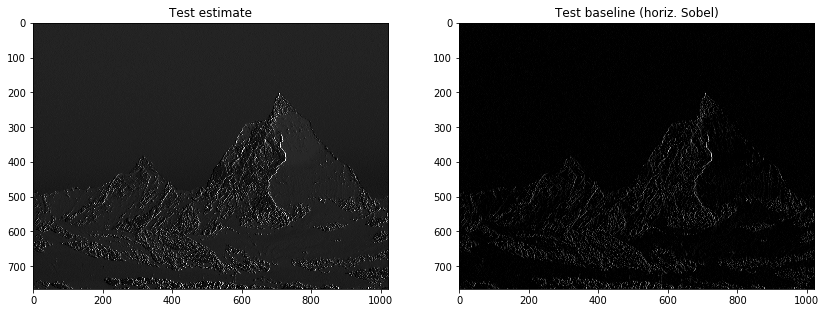

In [26]:
testImage = matterhornGray.reshape(1, testImageHeight, testImageWidth, 1) / 255
testEst2 = model2.predict(testImage)
testEstEdges2 = np.clip((testEst2.reshape(testImageHeight-2, testImageWidth-2)) * 255, 0, 255)

plt.figure(figsize=(14, 8))
plt.subplot(1,2,1)
plt.imshow(testEstEdges2, cmap='gray');
plt.title('Test estimate');
plt.subplot(1,2,2)
plt.imshow(testEstEdges0, cmap='gray');
plt.title('Test baseline (horiz. Sobel)');

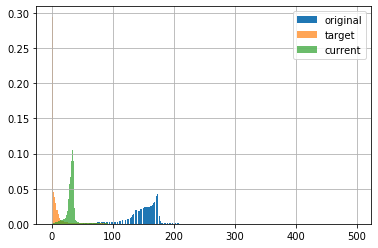

In [27]:
plt.hist((testImage.reshape(-1) * 255), 255, density=True, label='original')
plt.hist(testEstEdges0.reshape(-1), 255, density=True, alpha=0.7, label='target')
plt.hist(testEstEdges2.reshape(-1), 255, density=True, alpha=0.7, label='current');
plt.legend()
plt.grid();